In [1]:
import matplotlib as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from libs.ds_charts import get_variable_types
import libs.ds_charts as ds


# Missing values imputation

In [12]:
dataset_1 = pd.read_csv('dataset_1/NYC_collisions_tabular.csv', na_values='NaN')
new_dataset_1 = dataset_1.copy()

#FIND VARIABLES WITH MISSING VALUES
mv = {}
for var in new_dataset_1:
    nr = new_dataset_1[var].isna().sum()
    if nr > 0:
        mv[var] = nr

#DISCARD COLUMNS WITH MORE THEN 90% MISSING VALUES
threshold = new_dataset_1.shape[0] * 0.85

missings = [c for c in mv.keys() if mv[c]>threshold]
new_dataset_1.drop(columns=missings, inplace=True)
print('Dropped variables', missings)

#DISCARD RECORDS WITH MAJORITY OF MISSING VALUES
threshold = new_dataset_1.shape[1] * 0.50

new_dataset_1.dropna(thresh=threshold, inplace=True)
print(new_dataset_1.shape)

#PERSON_AGE
person_age = dataset_1['PERSON_AGE']
mean_ages = int(person_age.mean())
new_dataset_1['PERSON_AGE'].fillna(mean_ages,inplace=True)

#SAFETY_EQUIPMENT
new_dataset_1['SAFETY_EQUIPMENT'].fillna('Unknown',inplace=True)

#EJECTION
new_dataset_1['EJECTION'].fillna('Not Ejected',inplace=True)

#VEHICLE_ID
new_dataset_1['VEHICLE_ID'].dropna(inplace=True)

#POSITION IN VEHICLE
new_dataset_1['POSITION_IN_VEHICLE'].fillna('Unknown',inplace=True)
new_dataset_1.dropna(inplace=True)


Dropped variables ['PED_LOCATION', 'CONTRIBUTING_FACTOR_2', 'CONTRIBUTING_FACTOR_1', 'PED_ACTION']
(45669, 17)


### Dummification

In [13]:
file = 'nyc_collisions'
filename = 'data/nyc_collisions.csv'
symbolic_vars = ['BODILY_INJURY','SAFETY_EQUIPMENT','PERSON_SEX','EJECTION','PERSON_TYPE','COMPLAINT','EMOTIONAL_STATUS','POSITION_IN_VEHICLE','PED_ROLE']

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names_out(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

variables = get_variable_types(new_dataset_1)
new_dataset_1 = dummify(new_dataset_1, symbolic_vars)
new_dataset_1.to_csv(f'data/{file}_dummified.csv', index=False)
nr = new_dataset_1.isna().sum()
#print(nr)
#df.describe(include=[bool])

### Outliers imputation

In [29]:
# AGE
new_dataset_1 = new_dataset_1[(new_dataset_1.PERSON_AGE < 110) & (new_dataset_1.PERSON_AGE > 0)]

## Scalling

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import subplots, show

'''
 we need to apply the transfomation and rejoin the data together in order
 to have a unique dataframe. They can only be applied to numerical data, 
 without any missing value. In order to do that, we are splitting our dataframe into three 
 dataframes, one for each data type: above, discarding date variables, since the majority of 
 techniques are not able to deal with them.
'''

variable_types = get_variable_types(new_dataset_1)
numeric_vars = ['PERSON_AGE']
symbolic_vars2 = ['CRASH_DATE', 'CRASH_TIME']
boolean_vars = variable_types['Binary']

df_nr = new_dataset_1[numeric_vars]
df_sb = new_dataset_1[symbolic_vars2]
df_bool = new_dataset_1[boolean_vars]

#print(numeric_vars)
#print(symbolic_vars2)
#print(boolean_vars)

          PERSON_AGE BODILY_INJURY_Abdomen - Pelvis BODILY_INJURY_Back  \
count   39025.000000                          39025              39025   
unique           NaN                              2                  2   
top              NaN                          False              False   
freq             NaN                          38339              31995   
mean        0.353732                            NaN                NaN   
std         0.158175                            NaN                NaN   
min         0.000000                            NaN                NaN   
25%         0.242424                            NaN                NaN   
50%         0.323232                            NaN                NaN   
75%         0.454545                            NaN                NaN   
max         1.000000                            NaN                NaN   

       BODILY_INJURY_Chest BODILY_INJURY_Does Not Apply  \
count                39025                        39

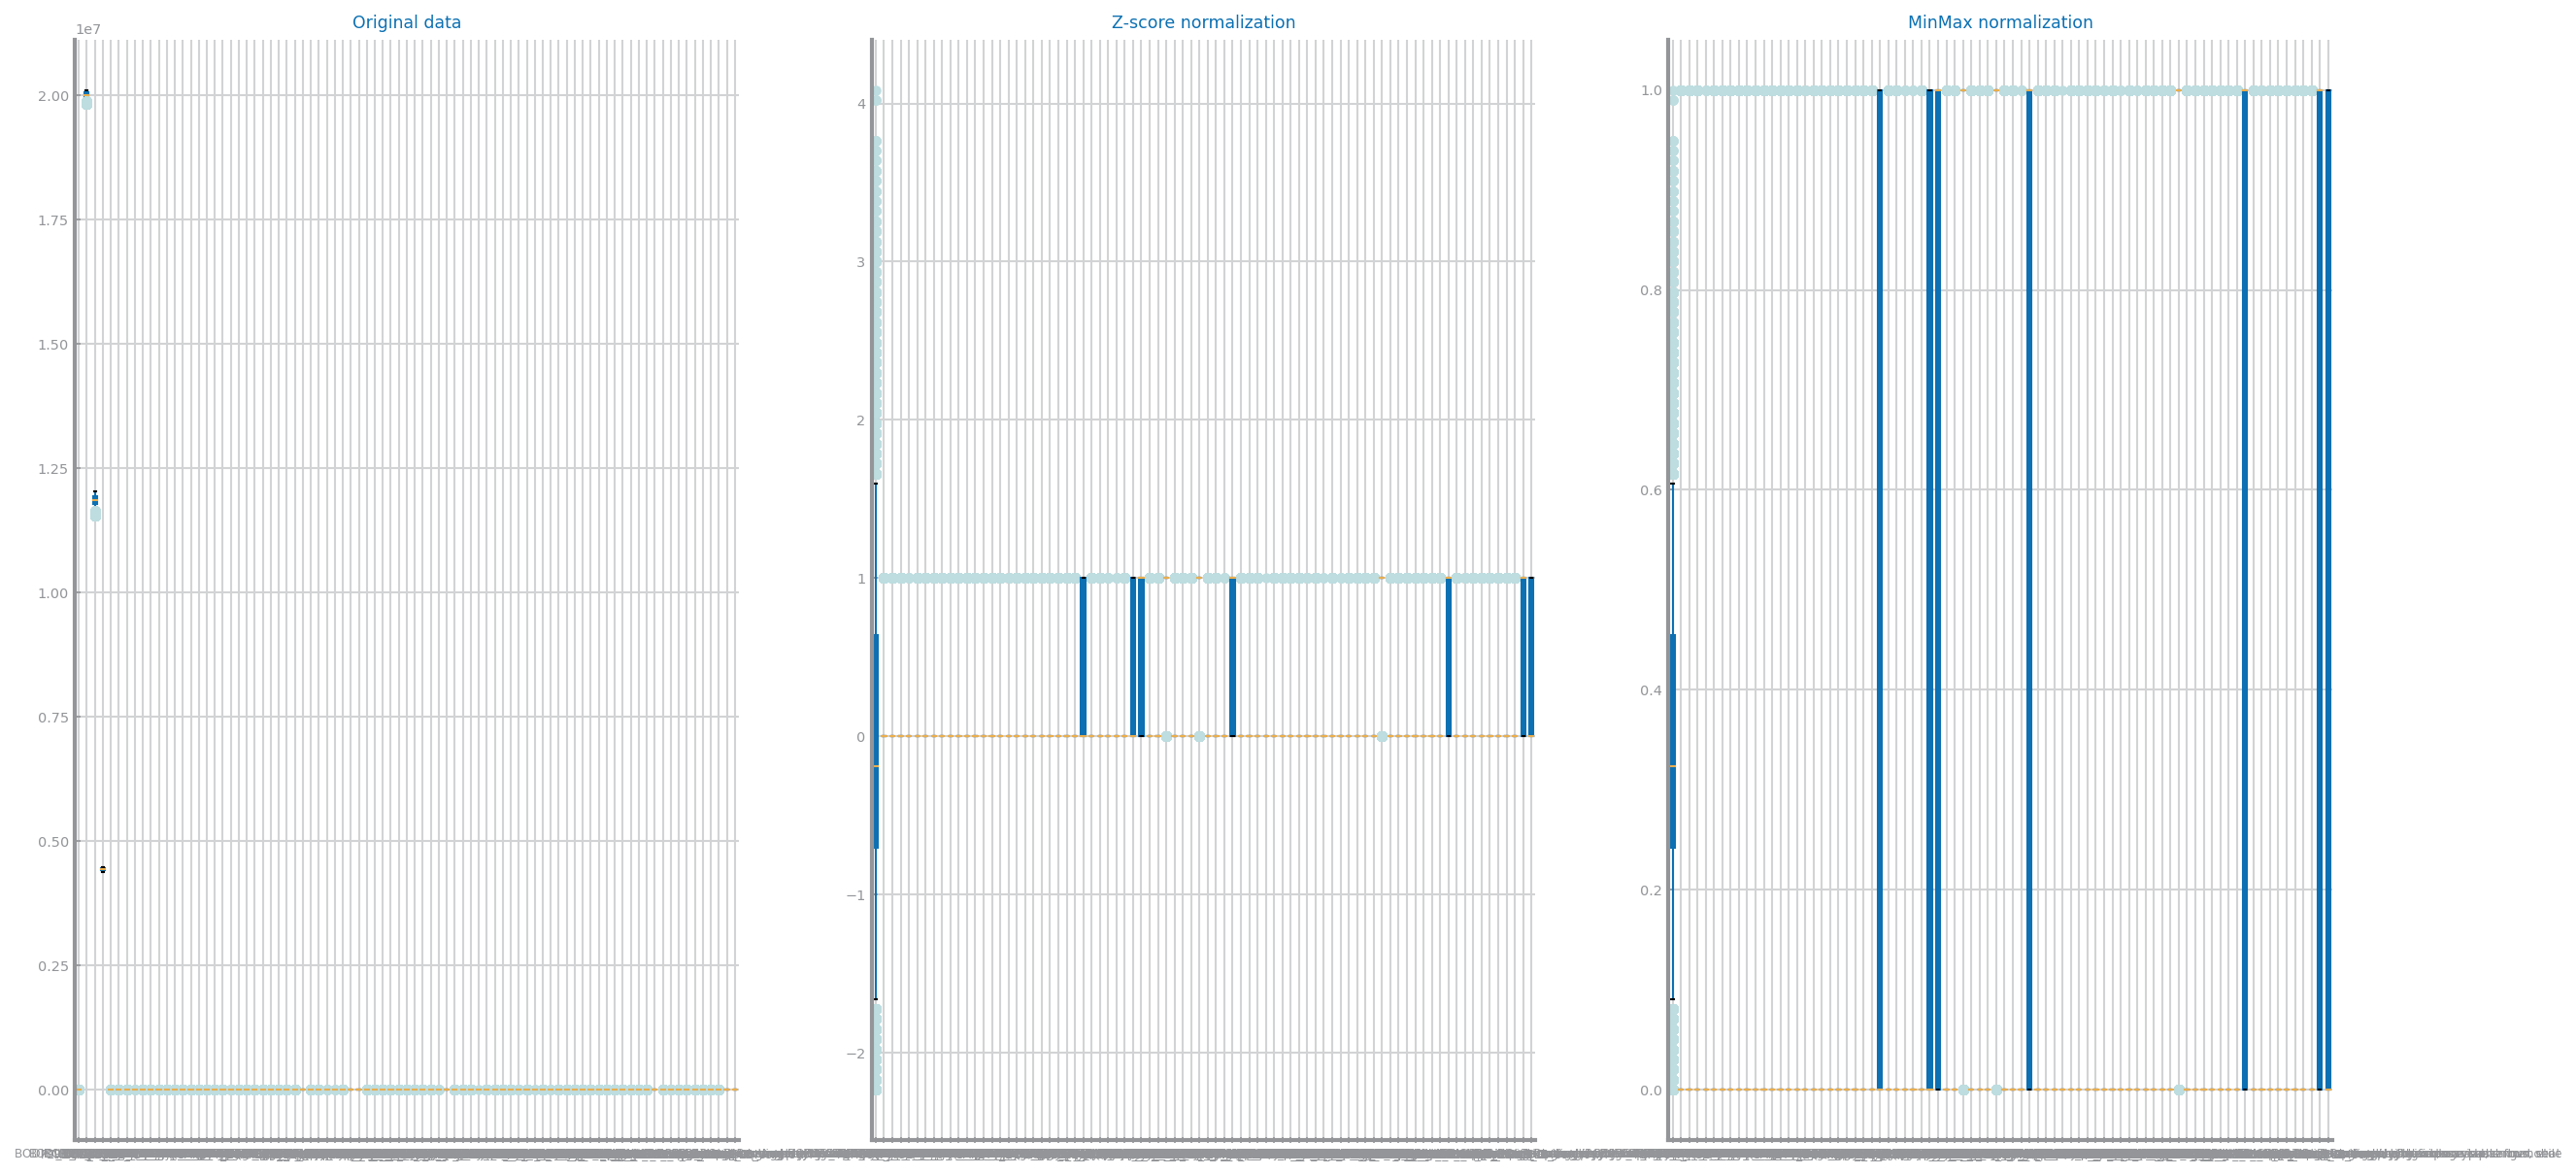

In [31]:
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_zscore = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'data/{file}_scaled_zscore.csv', index=False)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_minmax = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'data/{file}_scaled_minmax.csv', index=False)
print(norm_data_minmax.describe())
df = new_dataset_1
# Now we can se the result of the transformed data with a single boxplot, again.

fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

### TRAIN AND TEST ZSCORE

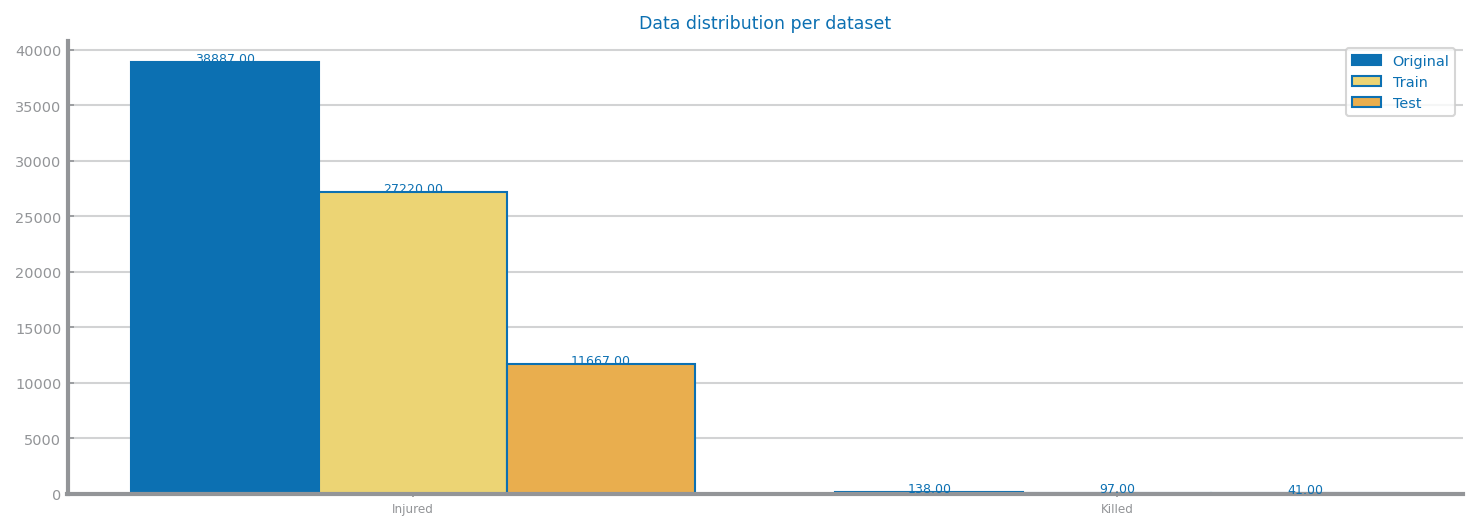

In [33]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_tag = 'nyc_collisions_scaled_zscore'
data: DataFrame = read_csv('data/nyc_collisions_scaled_zscore.csv')
target = 'PERSON_INJURY'
positive = 'Injured'
negative = 'Killed'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/{file_tag}_train.csv', index=False)

test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/{file_tag}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

### TRAIN AND TEST MINMAX

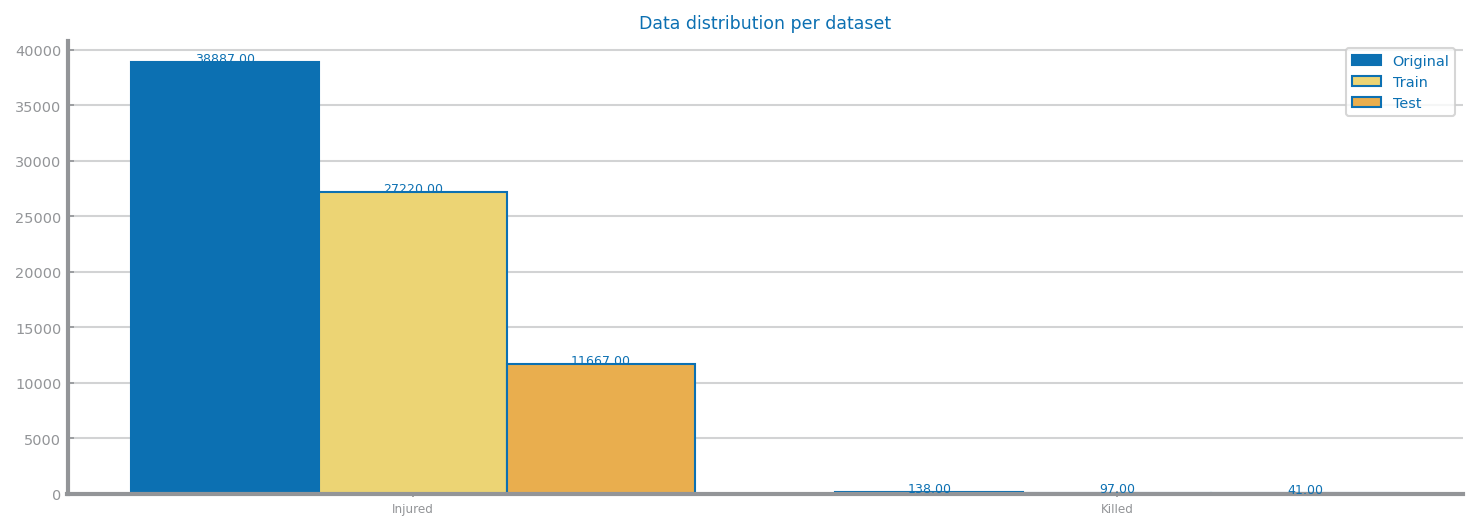

In [34]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_tag = 'nyc_collisions_scaled_minmax'
data: DataFrame = read_csv('data/nyc_collisions_scaled_minmax.csv')
target = 'PERSON_INJURY'
positive = 'Injured'
negative = 'Killed'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/{file_tag}_train.csv', index=False)

test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/{file_tag}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

### KNN DO ZSCORE

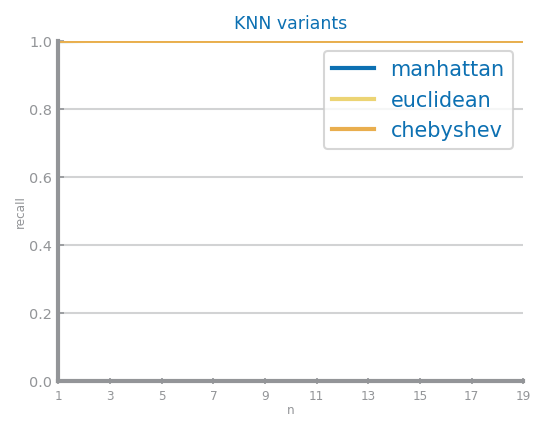

Best results with 3 neighbors and chebyshev


In [41]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from libs.ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score, recall_score

target = 'PERSON_INJURY'
filename = 'nyc_collisions_scaled_zscore'
train: DataFrame = read_csv(f'data/{filename}_train.csv')
train.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'data/{filename}_test.csv')
test.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(recall_score(tstY, prdY, pos_label='Injured'))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='recall', percentage=True)
savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

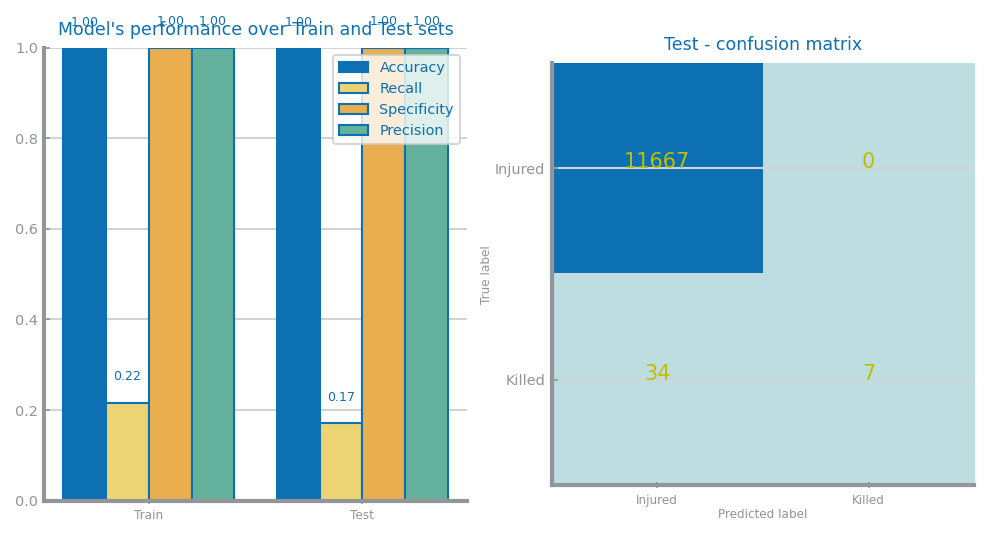

In [42]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig('images/{file_tag}_knn_best_ds1.png')
show()

### KNN DO MINMAX

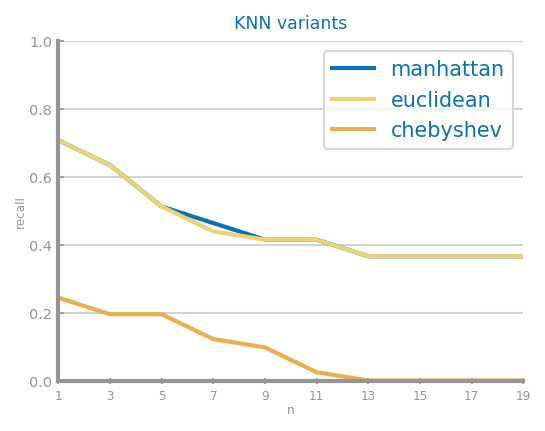

Best results with 1 neighbors and manhattan


In [45]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from libs.ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score, recall_score

target = 'PERSON_INJURY'
filename = 'nyc_collisions_scaled_minmax'
train: DataFrame = read_csv(f'data/{filename}_train.csv')
train.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'data/{filename}_test.csv')
test.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(recall_score(tstY, prdY, pos_label='Killed'))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='recall', percentage=True)
savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

In [ ]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig('images/{file_tag}_knn_best_ds1.png')
show()